# Atmospheric Composition and Structure

Supplement to Chapter 1 of [_A First Course in Atmospheric Thermodynamics_ by Grant W. Petty, Sundog Publishing, 2008](https://sundogpublishingstore.myshopify.com/products/a-first-course-in-atmospheric-thermodynamics-g-w-petty)

## Update to Figure 1.4: CO$_2$ concentration measured at Mauna Loa 
Also known as the "Keeling Curve"
![CO2 timeseries](https://scripps.ucsd.edu/bluemoon/co2_400/mlo_full_record.png)

Source: https://keelingcurve.ucsd.edu ([CC BY license](https://creativecommons.org/licenses/by/4.0/))



## An observed temperature profile (Figure 1.5)

You can browse upper-air observations archived at the University of Wyoming at this site: <http://weather.uwyo.edu/upperair/sounding.html>

Below we are going to access the same data in a Python script. As you can see below, we regenerate the temperature plot in Figure 1.5 by querying the data base for the correct station, date, and time.

We will probably dive deeper into how some of this code works later. For now, the important point is that we can easily access and plot radiosonde observations for arbitrary stations and dates.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from metpy.units import units
from metpy.plots import SkewT
from siphon.simplewebservice.wyoming import WyomingUpperAir

In [2]:
date = datetime(2004, 9, 8, 12) # year, month, day, hour (12Z)
station = 'DDC'  # station code for Dodge City, Kansas
df = WyomingUpperAir.request_data(date, station)
pressure = df['pressure'].values * units(df.units['pressure'])
temperature = df['temperature'].values * units(df.units['temperature'])

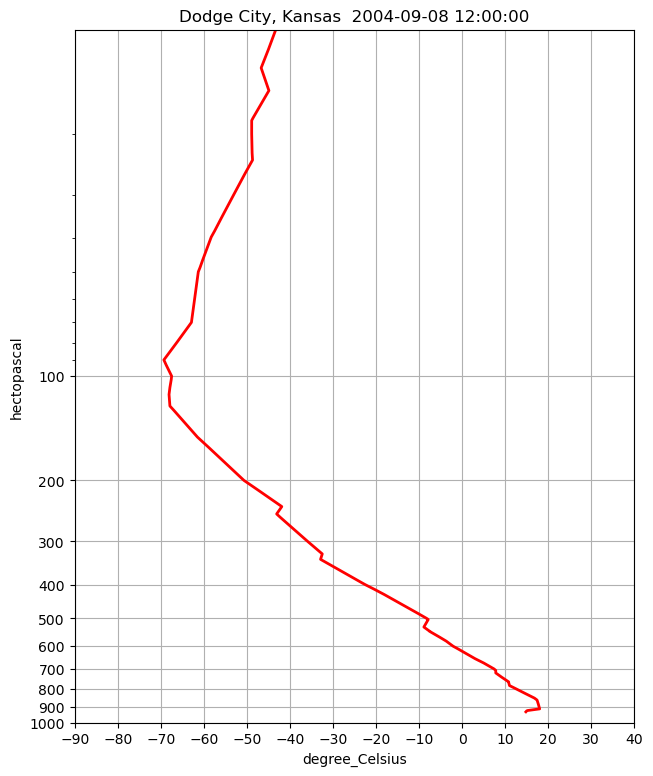

In [3]:
fig = plt.figure(figsize=(9, 9))
skew = SkewT(fig, rotation=0.)
skew.plot(pressure, temperature, 'r', linewidth=2)
skew.ax.set_xlim(-90,40)
skew.ax.set_ylim(1000,10)
skew.ax.set_title(f'Dodge City, Kansas  {date}');

Compare against Figure 1.5 in the text. It's exactly the same data! The only difference is how the vertical pressure axis is stretched.

We will use similar code many times during this course, but we will make some changes to how we plot the results.

## The US Standard Atmosphere (Figure 1.7)

Reproduction of Figure 1.7 under construction

## Summer versus Winter Temperature Profiles (Figure 1.8)

Here we recreate Figure 1.8 by accessing the radiosonde data for the same summer and winter dates as used in the book.

In [4]:
summer = datetime(2004, 7, 4, 0) # year, month, day, hour
winter = datetime(2004, 1, 27, 12)
summer_data = WyomingUpperAir.request_data(summer, station)
winter_data = WyomingUpperAir.request_data(winter, station)
summer_pressure = summer_data['pressure'].values * units('hPa')
summer_temperature = summer_data['temperature'].values * units('degC')
winter_pressure = winter_data['pressure'].values * units('hPa')
winter_temperature = winter_data['temperature'].values * units('degC')

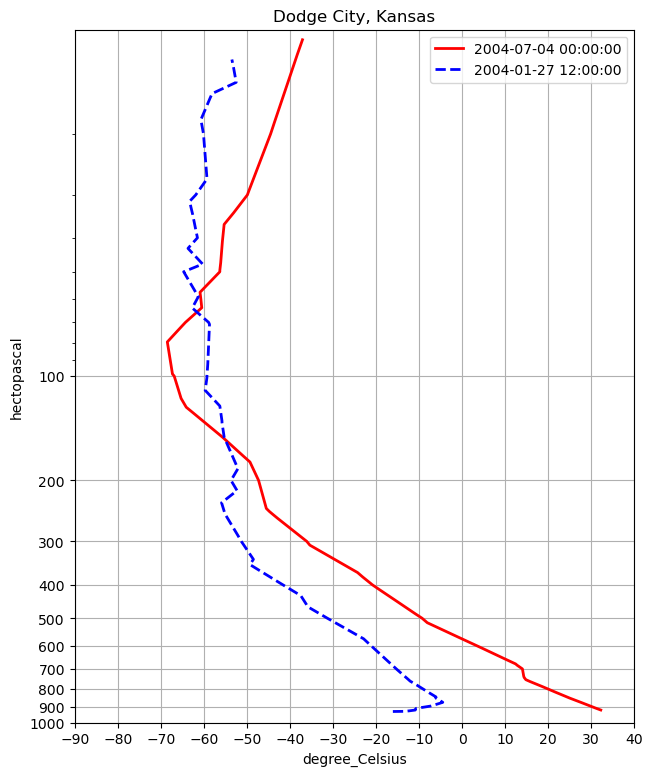

In [5]:
fig = plt.figure(figsize=(9, 9))
skew = SkewT(fig, rotation=0.)
skew.plot(summer_pressure, summer_temperature, 
          'r', linewidth=2, label=f'{summer}')
skew.plot(winter_pressure, winter_temperature,
          'b--', linewidth=2, label=f'{winter}')
skew.ax.set_xlim(-90,40)
skew.ax.set_ylim(1000,10)
skew.ax.set_title(f'Dodge City, Kansas');
skew.ax.legend()

## Tropical versus Arctic profiles (Figure 1.9)

In [6]:
# Under construction